In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


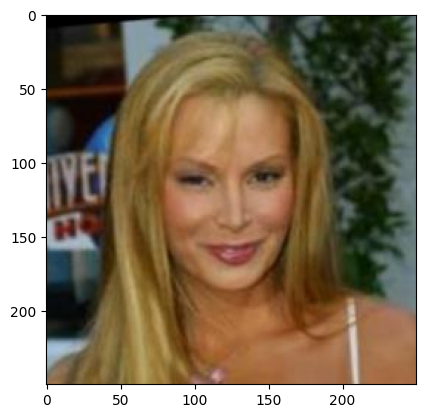

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Batch size: Indicates the number of images processed together in a batch. In this case, it is set to 32, as specified in the DataLoader.

Number of channels (RGB): Refers to the color channels in each image, and for RGB images, it is 3 (representing Red, Green, and Blue).

Image height: Represents the number of pixels along the vertical axis of each image, which is 250 pixels.

Image width: Denotes the number of pixels along the horizontal axis of each image, also set to 250 pixels.

Therefore, the shape of the sample_image tensor, [32, 3, 250, 250], signifies a batch of 32 color images, each having dimensions of 250x250 pixels.

In [6]:
for images, labels in dataloader:
    print("Sample images shape:", images.shape)
    batch_size, channels, height, width = images.shape
    print("Batch size:", batch_size)
    print("Number of channels (RGB):", channels)
    print("Image width:", width)
    print("Image height:", height)
    break


Sample images shape: torch.Size([32, 3, 250, 250])
Batch size: 32
Number of channels (RGB): 3
Image width: 250
Image height: 250


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [7]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # Encoder
        self.encoded = self.encoder()
        # Decoder
        self.decoded = self.decoder()

    def encoder(self):
         model_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2), 
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2), 
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  
            nn.ReLU()
        )
         return model_encoder

    def decoder(self):
        model_deocder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=2), 
            nn.Sigmoid()
        )
        return model_deocder

    def forward(self, x):
        x = self.encoded(x)
        x = self.decoded(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [8]:
# Create an instance of the model
model = AE()
# Get a batch of images from the DataLoader
for images, label in dataloader:
    # Check the shape of the output from the encoder and decoder
    output_of_encoder = model.encoded(images)
    print(output_of_encoder.shape)

    output_of_decoder = model.decoded(output_of_encoder)
    print(output_of_decoder.shape)

    forward_completed = model(images)

    print(forward_completed.shape)

    break  # Breaking the loop after processing the first batch


torch.Size([32, 256, 16, 16])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 2168931


In [10]:
loss_function = nn.MSELoss()


Autoencoders aim to capture the essential features of input data (x) in a compact latent space (z) and reconstruct the original data into new images (x_hat) through a process of encoding (X -> Z) and decoding (Z -> X_hat).

The goal is to create generated data that closely mirrors the original data, with a preference for a minimal latent space to enhance computational efficiency. To achieve this, the Mean Squared Error (MSE) loss function is chosen, as it quantifies the average squared difference between the input data and the reconstructed output. By minimizing the MSE, the model is incentivized to produce reconstructions closely resembling the original input data. The MSE's emphasis on squaring value differences also means it penalizes larger errors more significantly.

I used MSE loss function to train autoencoders, emphasizing the importance of generating reconstructions that faithfully capture the characteristics of the input data. The MSE loss effectively guides the model towards minimizing discrepancies between the input and reconstructed data.

In [12]:
import torch.optim as optim
optim = optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

**If your loss is not decreasing what do you have to do to trouble shoot it?**

Adjust Learning Rate:
If your learning rate is too high, it might lead to oscillations or instability. Try reducing it.
Conversely, if the learning rate is too low, the model may converge very slowly. Experiment with higher learning rates.

Evaluate Model Complexity:
Assess whether your model is too simple or too complex for the given task.
Experiment with adjusting the model architecture by adding or removing layers, changing the number of units, or altering the network structure.

Check for Overfitting:
If your model is too complex, it might be overfitting to the training data.
Consider adding regularization techniques such as dropout or L1/L2 regularization to prevent overfitting.

Explore Different Loss Functions:
Depending on the task, consider trying different loss functions. Some tasks might benefit from custom loss functions that align better with the problem at hand.

In [13]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

In [14]:
from torchvision.utils import save_image
for epoch in range(200):
    total_loss = 0
    for x,y in dataloader:
        #Forward
        decoded_images = model.forward(x)
        loss = loss_function(decoded_images, x)
        #Backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        break;

epoch 1/200 - loss:0.0905
epoch 2/200 - loss:0.0937
epoch 3/200 - loss:0.0968
epoch 4/200 - loss:0.1029
epoch 5/200 - loss:0.0852
epoch 6/200 - loss:0.0643
epoch 7/200 - loss:0.0434
epoch 8/200 - loss:0.0446
epoch 9/200 - loss:0.0420
epoch 10/200 - loss:0.0527
epoch 11/200 - loss:0.0519
epoch 12/200 - loss:0.0491
epoch 13/200 - loss:0.0513
epoch 14/200 - loss:0.0606
epoch 15/200 - loss:0.0440
epoch 16/200 - loss:0.0444
epoch 17/200 - loss:0.0452
epoch 18/200 - loss:0.0421
epoch 19/200 - loss:0.0441
epoch 20/200 - loss:0.0376
epoch 21/200 - loss:0.0386
epoch 22/200 - loss:0.0350
epoch 23/200 - loss:0.0479
epoch 24/200 - loss:0.0357
epoch 25/200 - loss:0.0392
epoch 26/200 - loss:0.0379
epoch 27/200 - loss:0.0325
epoch 28/200 - loss:0.0359
epoch 29/200 - loss:0.0406
epoch 30/200 - loss:0.0298
epoch 31/200 - loss:0.0294
epoch 32/200 - loss:0.0294
epoch 33/200 - loss:0.0373
epoch 34/200 - loss:0.0265
epoch 35/200 - loss:0.0285
epoch 36/200 - loss:0.0245
epoch 37/200 - loss:0.0256
epoch 38/2

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

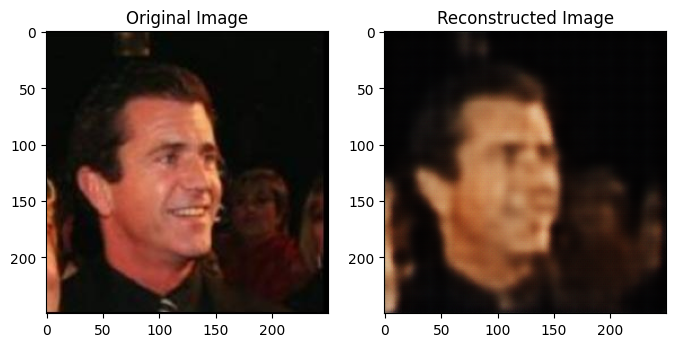

In [18]:
for images,label in dataloader:
    original_image = images[21]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np)
    axes[1].set_title('Reconstructed Image')

    # Show the plot
    plt.show()

    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

**How is adding noise affecting the decoded image?**

Incorporating noise from a normal distribution into the latent (hidden) representation of an autoencoder can induce various changes in the decoded image.

Initially, this approach serves to fortify the decoder's capabilities. By introducing noise to the latent representation, the decoder is compelled to adeptly reconstruct the original image, even in the presence of slight perturbations in the latent space. This process reduces the decoder's sensitivity to minor variations in the latent representation, thereby improving the quality of the decoded image.

Another valuable outcome is the prevention of overfitting. Overfitting occurs when a model precisely replicates the training data but performs poorly on unfamiliar data. Introducing noise to the latent representation encourages the model to learn more generalized properties of the data, potentially enhancing its performance on unseen data and mitigating overfitting issues.

It's important to note that the impact of adding noise to the latent representation depends on the specific characteristics of both the data and the noise. Excessive noise may overpower the signal in the latent representation, leading to a degradation in the quality of the decoded image or additional distortion. Conversely, if the noise is too subtle, its effect on the decoder's robustness or the model's generalization capability may be minimal.

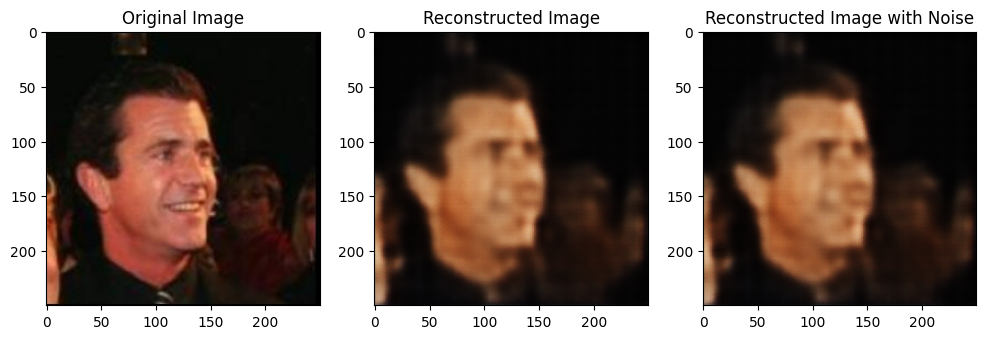

In [19]:
# Get the latent representation from the encoder
with torch.no_grad():
    latent_representation = model.encoded(original_image.unsqueeze(0))

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.1  # You can adjust the noise level
noisy_latent_representation = latent_representation + noise

# Decode the noisy latent representation
with torch.no_grad():
    reconstructed_noisy_image = model.decoded(noisy_latent_representation)

# Clamp pixel values to the valid range [0, 1]
reconstructed_noisy_image = torch.clamp(reconstructed_noisy_image, 0, 1)

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = model.decoded(latent_representation).squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Explicitly check and clamp pixel values
original_image_np = np.clip(original_image_np, 0, 1)
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
reconstructed_noisy_image_np = np.clip(reconstructed_noisy_image_np, 0, 1)

# Plot the original, reconstructed, and reconstructed with noise images side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

axes[2].imshow(reconstructed_noisy_image_np)
axes[2].set_title('Reconstructed Image with Noise')

plt.show()